In [2]:
!unzip -q /content/drive/MyDrive/train_images.zip -d /content

In [3]:
!unzip -q /content/drive/MyDrive/test_images.zip -d /content

# Note: The final/best model is at the end of the notebook in the last section. The first few sections have trial and error and incorrect models.

# Single Combined Architecture

I was following the old project handout where it said only sub-classes will be novel. Hence the following model is not accurate.

In [1]:
# Setup & Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks

# For Google Colab: mount your Drive (if your data lives there)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports & constants
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

IMAGE_DIR    = "/content/train_images"
CSV_PATH     = "/content/drive/MyDrive/train_data.csv"
IMG_SIZE     = (8, 8)
BATCH_SIZE   = 32
NUM_SUPER    = 3
NUM_SUBCLASS = 88                   # 87 real + 1 novel

# Load CSV & build filepaths
df = pd.read_csv(CSV_PATH)
df['filename'] = df['image'].astype(str)

# Train/val split (stratify on superclass to keep distribution balanced)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['superclass_index']
)


def parse_image(filename, super_idx, sub_idx):
    # read + decode
    path = tf.strings.join([IMAGE_DIR, "/", filename])
    img  = tf.io.read_file(path)
    img  = tf.image.decode_jpeg(img, channels=3)
    # resize & normalize
    img  = tf.image.resize(img, IMG_SIZE)
    img  = img / 255.0
    return img, {
        "superclass_output": super_idx,
        "subclass_output":   sub_idx
    }

def make_dataset(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df['filename'].values,
         df['superclass_index'].values,
         df['subclass_index'].values)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df,   shuffle=False)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

Train size: 5030, Val size: 1258


In [ ]:
# ─── Model Architecture (Two-Headed) ───

from tensorflow.keras import layers, Model

# Input
inputs = layers.Input(shape=(*IMG_SIZE, 3), name='image_input')

# 2. Shared Conv Backbone
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Super-class Head
super_out = layers.Dense(
    NUM_SUPER, activation='softmax', name='superclass_output'
)(x)

# Sub-class Head (includes “novel” class)
sub_out = layers.Dense(
    NUM_SUB, activation='softmax', name='subclass_output'
)(x)

# Model & Compile
model = Model(inputs=inputs, outputs=[super_out, sub_out])

model.compile(
    optimizer='adam',
    loss={
        'superclass_output': 'sparse_categorical_crossentropy',
        'subclass_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'superclass_output': 'accuracy',
        'subclass_output': 'accuracy'
    }
)

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 8, 8, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 8, 8, 32)  │        896 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 4, 4, 32)  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 4, 4, 64)  │     18,496 │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 2, 2, 64)  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 2, 2, 128) │     73,856 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 512)       │          0 │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ superclass_output   │ (None, 3)         │        771 │ dropout_16[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subclass_output     │ (None, 88)        │     22,616 │ dropout_16[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 247,963 (968.61 KB)

 Trainable params: 247,963 (968.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5777 - subclass_output_accuracy: 0.8067 - subclass_output_loss: 0.5609 - superclass_output_accuracy: 0.9946 - superclass_output_loss: 0.0167 - val_loss: 2.7750 - val_subclass_output_accuracy: 0.4698 - val_subclass_output_loss: 2.2854 - val_superclass_output_accuracy: 0.9110 - val_superclass_output_loss: 0.4534
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6219 - subclass_output_accuracy: 0.7842 - subclass_output_loss: 0.5933 - superclass_output_accuracy: 0.9894 - superclass_output_loss: 0.0286 - val_loss: 2.6654 - val_subclass_output_accuracy: 0.4714 - val_subclass_output_loss: 2.2553 - val_superclass_output_accuracy: 0.9293 - val_superclass_output_loss: 0.3799
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6301 - subclass_output_accuracy: 0.7917 - subclass_output_loss: 0.5898 - superclass_output_accuracy: 0.9848 - superclass_output_loss: 0.0403 - val_loss: 2.6825 - val_subclass_output_accur

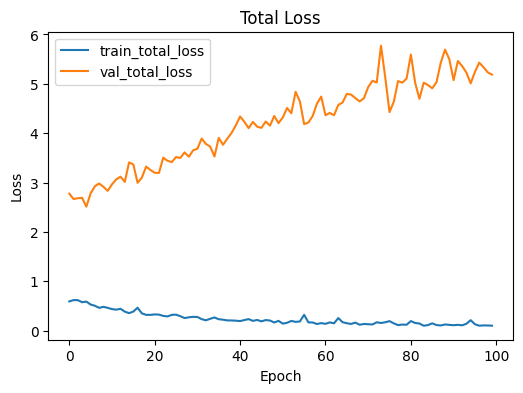

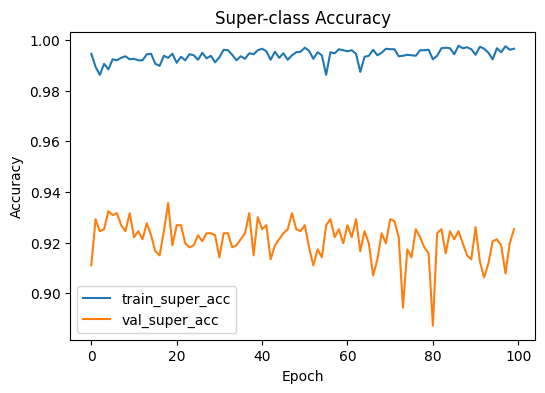

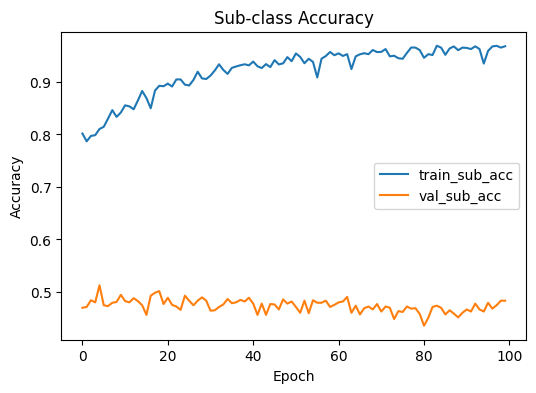

In [ ]:
# ─── Training & Viewing Results ───

import matplotlib.pyplot as plt

# Train
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Inspect history keys
print("History keys:", history.history.keys())

# Plot losses
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_total_loss')
plt.plot(history.history['val_loss'], label='val_total_loss')
plt.title('Total Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.show()

# 4. Plot super-class accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['superclass_output_accuracy'],   label='train_super_acc')
plt.plot(history.history['val_superclass_output_accuracy'], label='val_super_acc')
plt.title('Super-class Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 5. Plot sub-class accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['subclass_output_accuracy'],     label='train_sub_acc')
plt.plot(history.history['val_subclass_output_accuracy'],   label='val_sub_acc')
plt.title('Sub-class Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# ─── Novel‐Class Thresholding ──────────────────────

import numpy as np

# Define your threshold and novel‐class index
THRESHOLD_NOVEL   = 0.5               # probability cutoff for “known” subclasses
NOVEL_CLASS_INDEX = NUM_SUB - 1       # assume your last index is the “novel” bucket

def predict_with_novel(model, images):
    """
    Run the two‐headed model and threshold the subclass head.

    Args:
      model: your compiled two‐headed Keras model
      images: numpy array or tf.Tensor of shape (batch, H, W, 3), values [0,1]

    Returns:
      super_preds: array of shape (batch,) with superclass indices
      sub_preds:   array of shape (batch,) with subclass indices,
                   where =NOVEL_CLASS_INDEX indicates “novel”
    """
    # get raw softmax outputs
    super_probs, sub_probs = model.predict(images)

    # initial argmax predictions
    super_preds = np.argmax(super_probs, axis=-1)
    sub_best    = np.argmax(sub_probs,  axis=-1)
    sub_conf    = np.max(sub_probs,      axis=-1)

    # threshold: anything below THRESHOLD_NOVEL → novel
    sub_preds = sub_best.copy()
    sub_preds[sub_conf < THRESHOLD_NOVEL] = NOVEL_CLASS_INDEX

    return super_preds, sub_preds


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# ─── Load Test Images ─────────────
TEST_DIR = "/content/test_images"
test_filenames = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith(".jpg")])

def parse_test(filename):
    # filename: tf.string scalar like b"1.jpg"
    path = tf.strings.join([TEST_DIR, "/", filename])
    img  = tf.io.read_file(path)
    img  = tf.image.decode_jpeg(img, channels=3)
    img  = tf.image.resize(img, IMG_SIZE)
    img  = img / 255.0
    return img, filename

test_ds = (
    tf.data.Dataset
      .from_tensor_slices(test_filenames)
      .map(parse_test, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

# ─── Inference + Thresholding ───────────
predictions = []
for batch_imgs, batch_fnames in test_ds:
    # Use your helper from Section 3
    super_preds, sub_preds = predict_with_novel(model, batch_imgs)

    for fname_tensor, sp, subp in zip(batch_fnames.numpy(), super_preds, sub_preds):
        fname = fname_tensor.decode("utf-8")  # e.g. "1.jpg"
        predictions.append({
            "image": fname,
            "superclass_index": int(sp),
            "subclass_index":   int(subp)
        })

# ───  Quick Inspection ───────────────
pred_df = pd.DataFrame(predictions)

print("First 10 predictions:")
print(pred_df.head(10), "\n")

print("Superclass distribution:")
print(pred_df["superclass_index"].value_counts(), "\n")

print("Subclass distribution (including novel):")
print(pred_df["subclass_index"].value_counts())

# ─── Section 7: Save to CSV ────────────────────────────────────────────────────
OUT_CSV = "test_predictions.csv"
pred_df.to_csv(OUT_CSV, index=False)
print(f"\nSaved all predictions to {OUT_CSV}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

# Two-Tier


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths / hyperparams
IMAGE_DIR           = "/content/train_images"
CSV_PATH            = "/content/drive/MyDrive/train_data.csv"
IMG_SIZE            = (8, 8)
BATCH_SIZE          = 32
NUM_SUPER           = 3
NUM_SUB_REAL        = 87   # number of *real* subclasses
NOVEL_CLASS_INDEX   = NUM_SUB_REAL  # we'll use this index for “novel”
THRESHOLD_NOVEL     = 0.3  # if max subclass‐prob < this, predict novel
EPOCHS_SUPER        = 50
EPOCHS_SUB          = 100

In [ ]:
# Read CSV, append filenames
df = pd.read_csv(CSV_PATH)
df['filename'] = df['image'].astype(str)

# Split once (we'll reuse for both models)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['superclass_index']
)

# Parser function (returns img, label)
def parse_super(filename, super_idx):
    path = tf.strings.join([IMAGE_DIR, "/", filename])
    img  = tf.io.read_file(path)
    img  = tf.image.decode_jpeg(img, channels=3)
    img  = tf.image.resize(img, IMG_SIZE) / 255.0
    return img, super_idx

def parse_sub(filename, sub_idx):
    path = tf.strings.join([IMAGE_DIR, "/", filename])
    img  = tf.io.read_file(path)
    img  = tf.image.decode_jpeg(img, channels=3)
    img  = tf.image.resize(img, IMG_SIZE) / 255.0
    return img, sub_idx

# Build datasets
def make_ds(df, parse_fn, label_col, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df['filename'].values, df[label_col].values)
    )
    if shuffle:
        ds = ds.shuffle(len(df), seed=42)
    ds = ds.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Superclass datasets:
train_ds_super = make_ds(train_df, parse_super, 'superclass_index', shuffle=True)
val_ds_super   = make_ds(val_df,   parse_super, 'superclass_index', shuffle=False)

# Subclass datasets: filter out any “novel” examples in training/validation
#train_sub_df = train_df[train_df['subclass_index'] < NOVEL_CLASS_INDEX]
#val_sub_df   = val_df[  val_df[  'subclass_index'] < NOVEL_CLASS_INDEX]

train_ds_sub = make_ds(train_sub_df, parse_sub, 'subclass_index', shuffle=True)
val_ds_sub   = make_ds(val_sub_df,   parse_sub, 'subclass_index', shuffle=False)


In [ ]:
# Define a simple CNN backbone + super-class head
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))

# Convolutional feature extractor
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)

# Classification head
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
super_out = layers.Dense(NUM_SUPER, activation='softmax', name='superclass')(x)

super_model = models.Model(inputs, super_out, name='cnn_superclass_model')

# Compile
super_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_super = super_model.fit(
    train_ds_super,
    validation_data=val_ds_super,
    epochs=EPOCHS_SUPER
)


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5103 - loss: 0.9820 - val_accuracy: 0.7583 - val_loss: 0.6069
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7846 - loss: 0.5512 - val_accuracy: 0.7742 - val_loss: 0.5489
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8348 - loss: 0.4389 - val_accuracy: 0.8569 - val_loss: 0.3846
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8454 - loss: 0.4066 - val_accuracy: 0.8569 - val_loss: 0.3592
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8727 - loss: 0.3449 - val_accuracy: 0.8649 - val_loss: 0.3639
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8839 - loss: 0.3157 - val_accuracy: 0.8760 - val_loss: 0.3279
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9033 - loss: 0.2612 - val_accuracy: 0.8855 - val_loss: 0.3237
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9060 - loss: 0.2672 - val_accuracy: 

In [ ]:
# Define a similar CNN for subclasses
inputs_s = tf.keras.Input(shape=(*IMG_SIZE, 3))

y = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs_s)
y = layers.MaxPooling2D((2,2))(y)

y = layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
y = layers.MaxPooling2D((2,2))(y)

y = layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)
y = layers.MaxPooling2D((2,2))(y)

y = layers.Flatten()(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
sub_out = layers.Dense(NUM_SUB_REAL, activation='softmax', name='subclass')(y)

sub_model = models.Model(inputs_s, sub_out, name='cnn_subclass_model')

# Compile
sub_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_sub = sub_model.fit(
    train_ds_sub,
    validation_data=val_ds_sub,
    epochs=EPOCHS_SUB
)


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0152 - loss: 4.4541 - val_accuracy: 0.0087 - val_loss: 4.4142
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0253 - loss: 4.3450 - val_accuracy: 0.0668 - val_loss: 3.9443
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0671 - loss: 3.8529 - val_accuracy: 0.1455 - val_loss: 3.3530
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1247 - loss: 3.3987 - val_accuracy: 0.1741 - val_loss: 3.1094
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1538 - loss: 3.1939 - val_accuracy: 0.1979 - val_loss: 2.8952
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1925 - loss: 2.9751 - val_accuracy: 0.2051 - val_loss: 2.8352
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2106 - loss: 2.8023 - val_accuracy: 0.2806 - val_loss: 2.5623
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2473 - loss: 2.6827 - val_ac

# Inference

In [ ]:
def two_tier_predict(image_tensor):
    """
    Args:
      image_tensor: single image, shape (H,W,3), values [0,1]
    Returns:
      super_pred: integer [0,NUM_SUPER)
      sub_pred:   integer [0,NUM_SUB_REAL] where =NUM_SUB_REAL indicates novel
    """
    # add batch dim
    img = tf.expand_dims(image_tensor, 0)

    # 1) super-class
    super_probs = super_model.predict(img)
    super_pred  = np.argmax(super_probs, axis=-1)[0]

    # 2) sub-class on same image
    sub_probs = sub_model.predict(img)[0]
    best_idx  = np.argmax(sub_probs)
    best_conf = sub_probs[best_idx]

    # 3) threshold to novel
    if best_conf < THRESHOLD_NOVEL:
        return super_pred, NOVEL_CLASS_INDEX
    else:
        return super_pred, best_idx


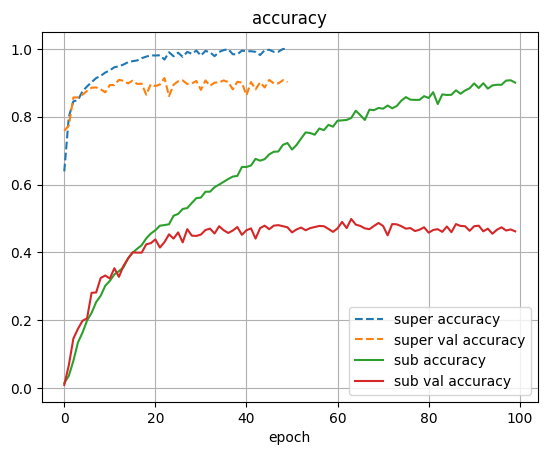

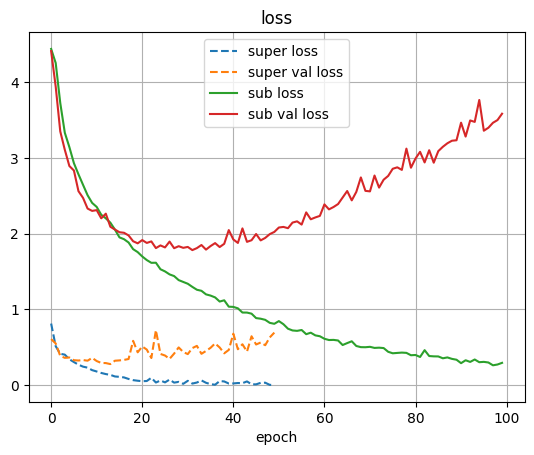

In [ ]:
# Combine histories
def plot_history(h1, h2, label):
    plt.plot(h1.history[label],  '--', label=f"super {label}")
    plt.plot(h1.history[f"val_{label}"], '--', label=f"super val {label}")
    plt.plot(h2.history[label],  '-',  label=f"sub {label}")
    plt.plot(h2.history[f"val_{label}"], '-',  label=f"sub val {label}")
    plt.title(label); plt.legend(); plt.xlabel('epoch'); plt.grid(True)
    plt.show()

# 6.1 Accuracy
plot_history(history_super, history_sub, 'accuracy')

# 6.2 Loss
plot_history(history_super, history_sub, 'loss')


In [ ]:
import os
import numpy as np
import pandas as pd

# List all filenames
TEST_DIR = "/content/test_images"
test_filenames = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith(".jpg")])

# Parser that emits (image_tensor, filename_str)
def parse_test(filename):
    path = tf.strings.join([TEST_DIR, "/", filename])
    img  = tf.io.read_file(path)
    img  = tf.image.decode_jpeg(img, channels=3)
    img  = tf.image.resize(img, IMG_SIZE) / 255.0
    return img, filename

# Build tf.data.Dataset
test_ds = (
    tf.data.Dataset
      .from_tensor_slices(test_filenames)
      .map(parse_test, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

#Run predictions
preds = []
for batch_imgs, batch_fnames in test_ds:
    # super-class
    super_probs = super_model.predict(batch_imgs)
    super_preds = np.argmax(super_probs, axis=-1)
    # sub-class
    sub_probs   = sub_model.predict(batch_imgs)
    best_idxs   = np.argmax(sub_probs, axis=-1)
    best_confs  = np.max(sub_probs, axis=-1)

    for fname, s_pred, s_idx, s_conf in zip(batch_fnames.numpy(), super_preds, best_idxs, best_confs):
        # threshold novel
        if s_conf < THRESHOLD_NOVEL:
            s_idx = NOVEL_CLASS_INDEX
        img_id = fname.decode("utf-8")
        preds.append({
            "image": img_id,
            "superclass_index": int(s_pred),
            "subclass_index":   int(s_idx)
        })


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━

In [ ]:
# Build a DataFrame
pred_df = pd.DataFrame(preds)

# Show first few rows
print(pred_df.head(10))

# Distribution of your top-level predictions
print("\nSuperclass counts:")
print(pred_df["superclass_index"].value_counts())

print("\nSubclass counts (including novel={}):".format(NOVEL_CLASS_INDEX))
print(pred_df["subclass_index"].value_counts())


       image  superclass_index  subclass_index
0      0.jpg                 1              70
1      1.jpg                 0              20
2     10.jpg                 0              84
3    100.jpg                 1              62
4   1000.jpg                 1               9
5  10000.jpg                 0              80
6  10001.jpg                 0              60
7  10002.jpg                 0              82
8  10003.jpg                 0              16
9  10004.jpg                 0              68

Superclass counts:
superclass_index
0    4935
2    3249
1    2996
Name: count, dtype: int64

Subclass counts (including novel=87):
subclass_index
4     619
68    490
84    370
1     356
16    342
     ... 
65     26
63     25
46     21
12     21
66     15
Name: count, Length: 88, dtype: int64


In [ ]:
OUT_CSV = "test_predictions.csv"
pred_df.to_csv(OUT_CSV, index=False)
print(f"\nSaved predictions → {OUT_CSV}")



Saved predictions → test_predictions.csv


# Final Solution Section - Multiheaded model, Thresholding softmax approach

In [38]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load CSV and build file paths
df = pd.read_csv("/content/drive/MyDrive/train_data.csv")
df['file_path'] = df['image'].astype(str)
df['file_path'] = df['file_path'].apply(lambda fn: os.path.join('train_images', fn))

# infer number of classes (including the “novel” slot)
num_superclasses = df['superclass_index'].max() + 1   # should be 4
num_subclasses  = df['subclass_index'].max()  + 1    # should be 88

# Stratified train/val split on superclass
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['superclass_index'],
    random_state=42
)

# Build tf.data pipeline
IMG_SIZE   = (64, 64)
BATCH_SIZE = 32

def process_path(path, sc_lbl, sub_lbl):
    # load + decode + resize + normalize
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    # one-hot encode both labels
    sc_lbl  = tf.one_hot(sc_lbl,  num_superclasses)
    sub_lbl = tf.one_hot(sub_lbl, num_subclasses)
    return img, {'superclass': sc_lbl, 'subclass': sub_lbl}

def df_to_dataset(dataframe, shuffle=True):
    paths   = dataframe['file_path'].values
    sc_lbls  = dataframe['superclass_index'].values
    sub_lbls = dataframe['subclass_index'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, sc_lbls, sub_lbls))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), seed=42)
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds   = df_to_dataset(val_df,   shuffle=False)


Model Architecture

In [42]:
# Build a two-head CNN with augmentations
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

# data-augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

inputs = layers.Input(shape=(*IMG_SIZE, 3))

# apply augmentations only during training
x = data_augmentation(inputs)

# feature extractor
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)

# two softmax heads
super_out = layers.Dense(num_superclasses, activation='softmax', name='superclass')(x)
sub_out   = layers.Dense(num_subclasses,   activation='softmax', name='subclass')(x)

model = Model(inputs, [super_out, sub_out])
model.summary()

# Compile & train
model.compile(
    optimizer='adam',
    loss={
        'superclass': tf.keras.losses.CategoricalCrossentropy(),
        'subclass':   tf.keras.losses.CategoricalCrossentropy()
    },
    metrics={
        'superclass': 'accuracy',
        'subclass':   'accuracy'
    }
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75
)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 64, 64, 3) │          0 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 64, 64,    │        896 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 32, 32,    │          0 │ conv2d_54[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_27… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 16, 16,    │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 16, 16,    │     36,928 │ max_pooling2d_28… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 16, 16,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 8, 8, 128) │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_58[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ superclass (Dense)  │ (None, 3)         │        771 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subclass (Dense)    │ (None, 87)        │     22,359 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 514,522 (1.96 MB)

 Trainable params: 514,394 (1.96 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/75
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 4.6831 - subclass_accuracy: 0.0382 - subclass_loss: 4.0841 - superclass_accuracy: 0.7301 - superclass_loss: 0.5991 - val_loss: 4.7352 - val_subclass_accuracy: 0.0429 - val_subclass_loss: 4.0438 - val_superclass_accuracy: 0.7679 - val_superclass_loss: 0.6905
Epoch 2/75
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4148 - subclass_accuracy: 0.1495 - subclass_loss: 3.1226 - superclass_accuracy: 0.8866 - superclass_loss: 0.2922 - val_loss: 4.2128 - val_subclass_accuracy: 0.0676 - val_subclass_loss: 3.7933 - val_superclass_accuracy: 0.8545 - val_superclass_loss: 0.4043
Epoch 3/75
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.8244 - subclass_accuracy: 0.2505 - subclass_loss: 2.5933 - superclass_accuracy: 0.9119 - superclass_loss: 0.2310 - val_loss: 6.8983 - val_subclass_accuracy: 0.0771 - val_subclass_loss: 6.3136 - val_superclass_accuracy: 0.7631 - val_superclass_loss: 0.5389
Epoch 4/75
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 

# Threshold Softmax and Final results csv

In [50]:

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

# ———  Thresholds & novel‐class indices ———
threshold_super = 0.95   # tune this on your val set
threshold_sub   = 0.90

novel_super_idx = 3     # novel super-class label
novel_sub_idx   = 87    # novel sub-class label

# ———  Gather & preprocess test images ———
test_paths = sorted(
    glob.glob("/content/test_images/*.jpg"),
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

def preprocess_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

test_ds = (
    tf.data.Dataset
      .from_tensor_slices(test_paths)
      .map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

# ———  Inference ———
super_probs, sub_probs = model.predict(test_ds, verbose=1)

# ———  Compute confidences & raw preds ———
super_conf = np.max(super_probs, axis=1)    # (N,)
super_arg  = np.argmax(super_probs, axis=1)

sub_conf   = np.max(sub_probs, axis=1)
sub_arg    = np.argmax(sub_probs, axis=1)

# ———  Apply threshold → final preds ———
# If confidence < threshold → novel_idx, else → argmax
super_pred = np.where(super_conf < threshold_super,
                      novel_super_idx,
                      super_arg)

sub_pred   = np.where(sub_conf < threshold_sub,
                      novel_sub_idx,
                      sub_arg)

# ———  Save to CSV ———
#image_ids = [os.path.splitext(os.path.basename(p))[0] for p in test_paths]
# extract image filenames (including “.jpg”)
image_ids = [os.path.basename(p) for p in test_paths]

df_out = pd.DataFrame({
    "image":            image_ids,
    "superclass_index": super_pred,
    "subclass_index":   sub_pred
})

df_out.to_csv("test_predictions.csv", index=False)
print(f"Wrote {len(df_out)} rows to test_predictions.csv")


350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Wrote 11180 rows to test_predictions.csv


The above code generates the final prediction result that is submitted to the leaderboard.